# Cálculo de Enlace
## Edificio Libertador (EMGE) - Campo de Mayo (Telepuerto Satelital EA)
### Autor: CT Carlos MACEIRA GARCIA CONI
---

1. Determinación del requerimiento:<br>
a. Terminal A: Planta Transmisora EA (Campo de Mayo - PBA). <br>
b. Terminal B: EMGE (Edificio Libertador - CABA).<br>
c. Necesidades ancho de banda: 32 enlaces E1 y un enlace de 300 Mbps.<br>
d. Disponibilidad: 99.99%.<br>

### Datos obtenidos del enlace:<br>
El tipo de terreno por donde pasará el enlace es llanura, pero debe tenerse
en cuenta que está la Ciudad Autonoma de Buenos Aires con sus
altas edificaciones en el camino. Los datos obtenidos provenientes de relevamientos del IGN se agregan como un archivo
de valores separados por comas. Los mismo corresponden a un levantamiento que alturas que incluye las edifciaciones
con una resolución de 5 metros cuadrados.

![alt text](img/fuente_datos.jpeg)

In [56]:
# Importación de las librerías de manejo de datos y de graficación
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint

In [57]:
# Lectura de los datos geográficos.
datos = pd.read_csv('data/puntosZ.csv', index_col='fid')
datos.head()

,LATITUD,LONGITUD,PROGRESIVA,Z
fid,,,,
1,-34.549768,-58.643817,0.00,18.03
2,-34.549815,-58.643605,20.11,14.37
3,-34.549861,-58.643393,40.23,13.89
4,-34.549908,-58.643182,60.34,13.64
5,-34.549954,-58.642970,80.46,12.85


El tipo de suelo predominante en el trayecto considerado es zona urbana, por
lo cual su conductividad $\sigma$ es de $7.5\times10^{-4}$ y su
permisividad es despreciable.

El clima de esta región es una variación del subtropical húmedo, también llamado templado, que se caracteriza porque la
estación más cálida es también la más lluviosa. Presenta veranos cálidos e inviernos frescos y variables, con heladas
frecuentes pero sin nevadas; la temperatura media anual es de 17 °C.

El coindice de refraccion para la zona según el Anexo 1 la recomendación UIT-R P.453-14 es de $N_0 = 350$ en
febrero y $N_0 = 330$ en agosto, y el gradiente de refractividad $\frac{\delta N}{\delta h} = 50$. Los vientos para la
zona de acuerdo a los datos recabados de https://windy.app/ son:

![alt text](img/vientos_caba.png)

La zona de acuerdo a la tabla 1 de Zonas Hidrometeorológicas de la recomendación UIT-R
 P.837-1 es K. La media anual de precipitación es de 1236,3 mm.

 De acuerdo a los datos geográficos la ubicación geográfica y altura de los puntos terminales es:



In [58]:
datos_terA = {'latitud':datos.iloc[0]['LATITUD'], 'longitud':datos.iloc[0]['LONGITUD'], 'altura':datos.iloc[0]['Z']}
datos_terB = {'latitud':datos.iloc[-1]['LATITUD'], 'longitud':datos.iloc[-1]['LONGITUD'], 'altura':datos.iloc[-1]['Z']}
print('Terminal A (Planta Transmisora):')
pprint.pprint(datos_terA)
print('Terminal B (Edificio Libertador):')
pprint.pprint(datos_terB)

Terminal A (Planta Transmisora):
{'altura': 18.03, 'latitud': -34.549768, 'longitud': -58.643817000000006}
Terminal B (Edificio Libertador):
{'altura': 48.26, 'latitud': -34.610084, 'longitud': -58.368091}


#### Perfil topográfico del terreno

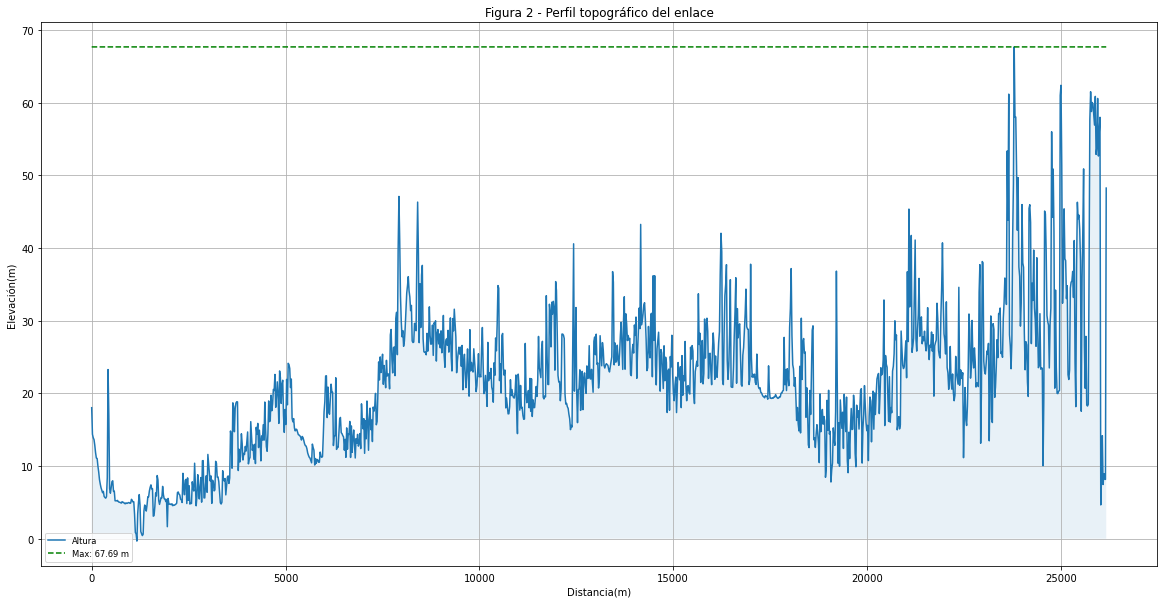

La máxima altura del perfil es: 67.69m a los 23794.89m de enlace 
La distancia de enlace es de 26168.35m


In [59]:
# Confección del perfil.
maxima_altura = datos['Z'].max()
posicion_maxalt = datos.loc[datos['Z'] == maxima_altura, 'PROGRESIVA'].iloc[0]
fig = plt.figure(figsize=(20,10))
plt.plot('PROGRESIVA','Z', data=datos, label='Altura')
vector_max = np.full(len(datos), maxima_altura)
plt.plot('PROGRESIVA',vector_max,'--g',label='Max: '+str(maxima_altura)+' m', data=datos)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],alpha=0.1)
plt.xlabel("Distancia(m)")
plt.ylabel("Elevación(m)")
plt.title("Figura 2 - Perfil topográfico del enlace")
plt.grid()
plt.legend(fontsize='small')
plt.show()

print("La máxima altura del perfil es: {}m a los {}m de enlace ".format(maxima_altura, posicion_maxalt))
print("La distancia de enlace es de {}m".format(datos.iloc[-1]['PROGRESIVA']))

### Repetidores Pasivos
Dado el perfil topográfico del enlace directo (Figura 2) no se considera necesario la instalación de repetidores pasivos.

### Frecuencia de transmision y ancho de banda requerido
El requerimiento del enlace especifica la necesidad de transmitir 32 canales E1 y un canal de datos de 300 Mbps. Dado
que la distancia de enlace es de 26,168 Km se elige aprovechar la banda no licenciada de 5150 - 5875 Mhz. Para hallar el
ancho de banda necesario:

$$R_{bit}= 32 \times E1 + Datos = 32 \times 2,048 Mbps + 300 Mbps = 365,536Mbps$$
$$R_{bitc}=\frac{R_{bit}}{FEC}=\frac{365,536Mbps}{5/6}=438,6432Mbps$$

Si la modulacion es 256QAM:

$$R_{simb}=\frac{R_{bitc}}{\log_2{m}}=\frac{438,6432Mbps}{\log_2{256}}=54,8304MBd$$

$$Bw_{rf}=1,2\times R_{simb} = 1,2\times R_{54,8304MBd} = 65,8 Mhz$$

### Longitud de onda
Para la banda no licencia de 5150 - 5875 Mhz la eleccion del canal que se configure en el equipo depende de un
relevamiento de la disponibilidad de canales a realizar en cada uno de los sitios de instalación, quedando fuera del
alcance del presente trabajo. Sin embargo la longitud de onda de la banda es de $5,17 cm $

### Nuevos perfiles de terreno segun los valores de K
Segun los datos recabados el gradiente de refractividad para verano es $\frac{\delta N}{\delta h} = 50$. Con el
se calcula el valor del Factor K para obtener el radio equivalente de la tierra:

$$ K = a \left (157+ \frac{\delta N}{\delta h} \right)\times 10^{-6}$$
$$ K = 6370 \left (157+ 50 \right)\times 10^{-6} = 1,319$$

Aplicando este factor al perfil de la figura 2:

In [60]:
# Calculo del valor de K
radio_tierra = 6370
gradiente = 50
K = radio_tierra*(157 + gradiente) * 10 ** -6

#### Calculo del despejamiento
Para realizar la correcion de la superficie terrestre a partir del valor de K obtenido a fin de que asegurar que llegue
toda la potencia prevista al receptor y no se produzcan atenuaciones por obstáculos se calcula $f(x)$ que representa
para cada punto de la distancia del enlace en cuánto se debe corregir la cota topografica.

$$f(x) = 0,07849 \times \frac{x\times (d-x)}{K} $$

In [61]:
# Cálculo del despejamiento f(x) = 0.07489 * ((x * (d - x))/ K)
x = np.array(datos['PROGRESIVA']) * (10 ** -3)
d = datos.iloc[-1]['PROGRESIVA'] * (10 ** -3)
despejamiento = 0.07849 * ((x * (d - x))/ K)

El vector despejamiento se suma al vector de cotas topográficas para obtener el perfil ficticio.

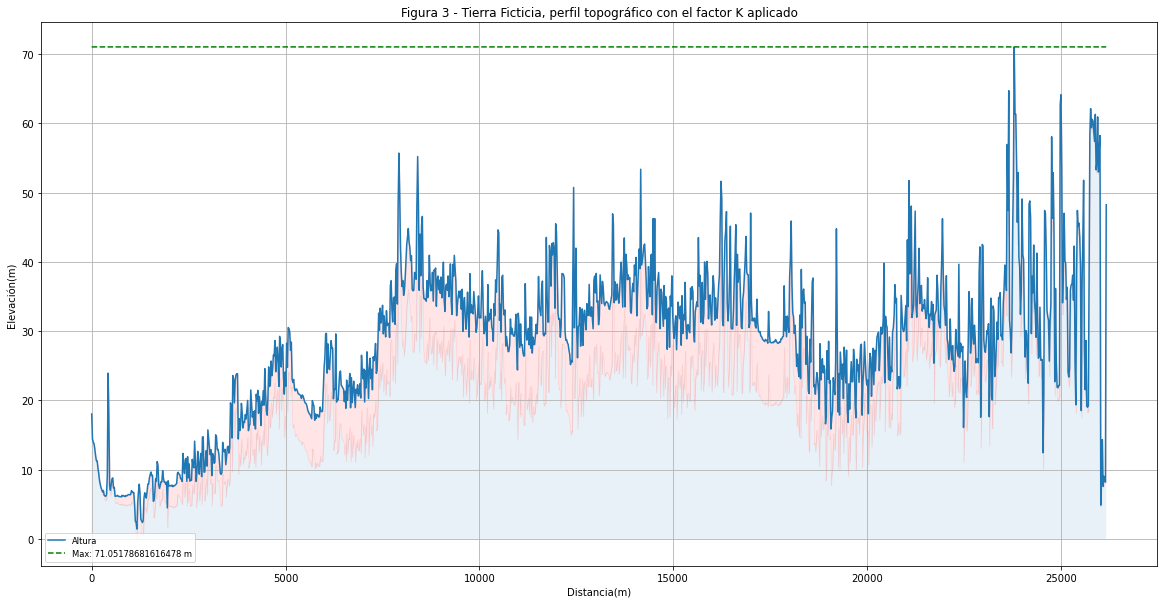

La máxima altura del perfil es: 71.05178681616478m a los 23794.89m de enlace 


In [62]:
# Confección del perfil de la tierra ficticia.
datos['Z_equivalente'] = datos['Z'] + despejamiento
maxima_altura = datos['Z_equivalente'].max()
posicion_maxalt = datos.loc[datos['Z_equivalente'] == maxima_altura, 'PROGRESIVA'].iloc[0]
fig = plt.figure(figsize=(20,10))
plt.plot('PROGRESIVA','Z_equivalente', data=datos, label='Altura')
vector_max = np.full(len(datos), maxima_altura)
plt.plot('PROGRESIVA',vector_max,'--g',label='Max: '+str(maxima_altura)+' m', data=datos)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],alpha=0.1)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],datos['Z_equivalente'],alpha=0.1, color='red')
plt.xlabel("Distancia(m)")
plt.ylabel("Elevación(m)")
plt.title("Figura 3 - Tierra Ficticia, perfil topográfico con el factor K aplicado")
plt.grid()
plt.legend(fontsize='small')
plt.show()
print("La máxima altura del perfil es: {}m a los {}m de enlace ".format(maxima_altura, posicion_maxalt))

Donde la zona sombreada en color rojo representa la variación causada por $f(x)$




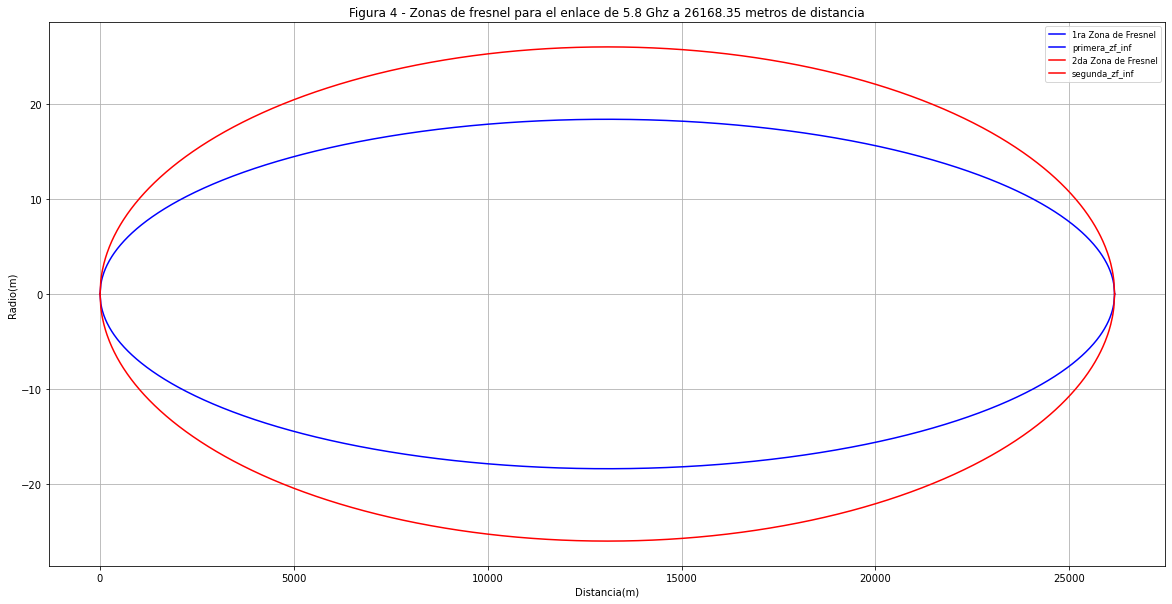

El radio máximo de la primer zona de Fresnel es de: 18.390914169879636
El radio máximo de la segunda zona de Fresnel es de: 26.008680243483315


In [63]:
distancias = np.array(datos['PROGRESIVA'])
distancias_rev = np.array(datos['PROGRESIVA'].sort_values(ascending=False))
distancia_total = distancias_rev[0]
longitud_onda = 0.0517
datos['primera_zf_sup'] = np.array(np.sqrt((distancias * distancias_rev * longitud_onda)/distancia_total))
datos['primera_zf_inf'] = (datos['primera_zf_sup'] * -1)
datos['segunda_zf_sup'] = datos['primera_zf_sup'] * (2 ** 0.5)
datos['segunda_zf_inf'] = datos['primera_zf_inf'] * (2 ** 0.5)
fig = plt.figure(figsize=(20,10))
plt.plot('PROGRESIVA', 'primera_zf_sup', color='blue', label='1ra Zona de Fresnel', data=datos)
plt.plot('PROGRESIVA', 'primera_zf_inf', color='blue', data=datos)
plt.plot('PROGRESIVA', 'segunda_zf_sup', color='red', label='2da Zona de Fresnel', data=datos)
plt.plot('PROGRESIVA', 'segunda_zf_inf', color='red', data=datos)
plt.xlabel("Distancia(m)")
plt.ylabel("Radio(m)")
plt.title(f'Figura 4 - Zonas de fresnel para el enlace de 5.8 Ghz a {distancia_total} metros de distancia')
plt.grid()
plt.legend(fontsize='small')
plt.show()
print(f'El radio máximo de la primer zona de Fresnel es de: {primera_zf_sup.max()}')
print(f'El radio máximo de la segunda zona de Fresnel es de: {segunda_zf_sup.max()}')

### Trazado de la Zonas de Fresnel segun la condición de despejamiento para la peor situación
Dado que se conoce la máxima altura del perfil ficticio, y ademas, para frecuencias mayores a 3 Ghz se requiere un 100%
de la R1 y 30% de la R2 despejada.

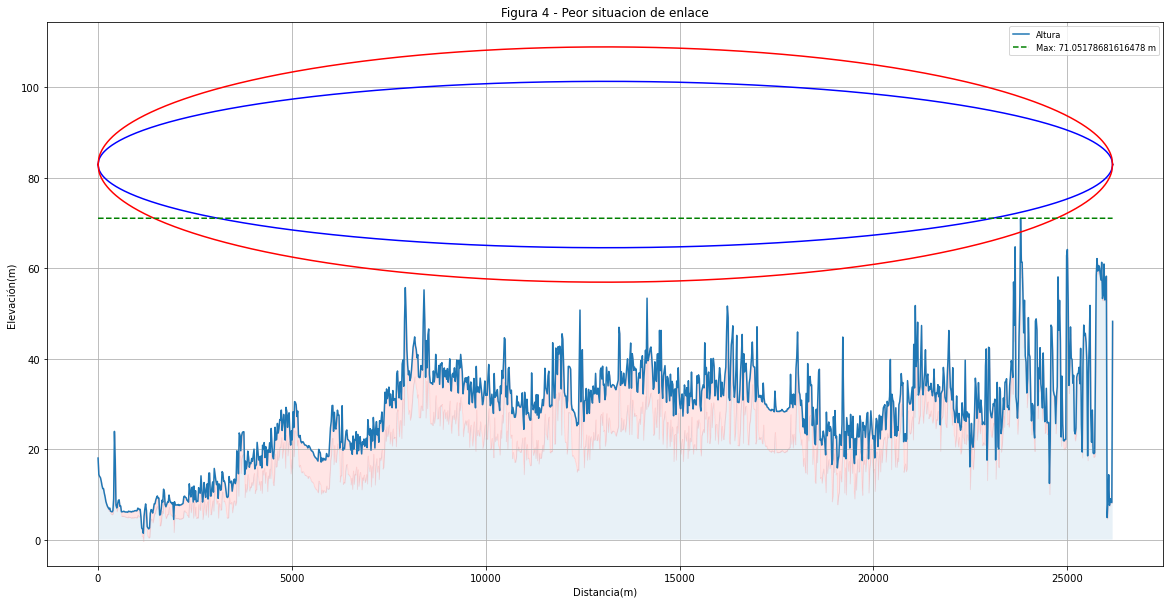

In [64]:
despejamiento_segunda_zf = (datos.loc[datos['Z_equivalente'] == maxima_altura, 'segunda_zf_inf'].iloc[0] -
                            datos.loc[datos['Z_equivalente'] == maxima_altura, 'primera_zf_inf'].iloc[0]) * 0.7
elevacion = maxima_altura + abs(datos.loc[datos['Z_equivalente'] == maxima_altura, 'segunda_zf_inf'].iloc[0]  - despejamiento_segunda_zf)
fig = plt.figure(figsize=(20,10))
plt.plot('PROGRESIVA','Z_equivalente', data=datos, label='Altura')
plt.plot(datos['PROGRESIVA'], datos['primera_zf_sup'] + elevacion, color='blue')
plt.plot(datos['PROGRESIVA'], datos['primera_zf_inf'] + elevacion, color='blue')
plt.plot(datos['PROGRESIVA'], datos['segunda_zf_sup'] + elevacion, color='red')
plt.plot(datos['PROGRESIVA'], datos['segunda_zf_inf'] + elevacion, color='red')
vector_max = np.full(len(datos), maxima_altura)
plt.plot('PROGRESIVA',vector_max,'--g',label='Max: '+str(maxima_altura)+' m', data=datos)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],alpha=0.1)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],datos['Z_equivalente'],alpha=0.1, color='red')
plt.xlabel("Distancia(m)")
plt.ylabel("Elevación(m)")
plt.title("Figura 4 - Peor situacion de enlace")
plt.grid()
plt.legend(fontsize='small')
plt.show()

Esta ubicación de los equipos es poco conveniente debido a la gran altura que debe tener una de las torres, situación que
puede no ser deseable. Se platea hallar la ecuación de una recta de la forma $ y = mx + b $ tal que minimice la altura de
ambas torres. Para ello se plantea obtener las coordenadas de los puntos de mayor altura de la primera y segunda mitad
del enlace.

La ecuacion de la recta de enlace es y = 0.0009663344896970469x + 48.05796393061741


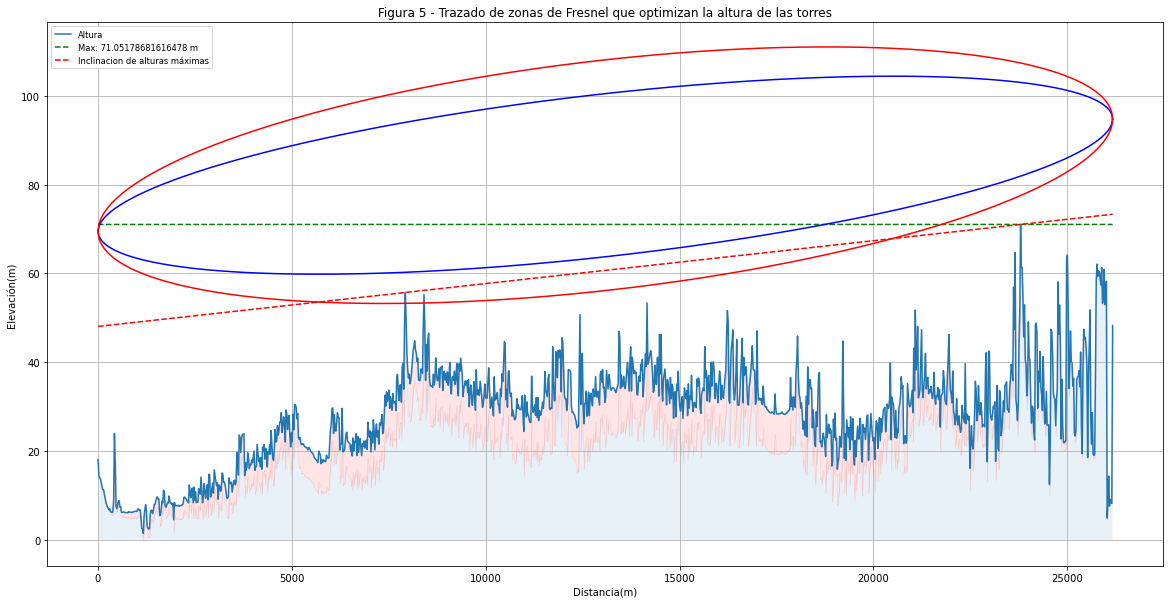

In [67]:
# Busqueda de la recta que optimice las alturas de las torres aplicandole inclinacion al enlace
alturas = np.array(datos['Z_equivalente'])
primer_mitad, segunda_mitad = np.array_split(alturas, 2)
y1 = primer_mitad.max()
y2 = segunda_mitad.max()
x1 = datos.loc[datos['Z_equivalente'] == y1, 'PROGRESIVA'].iloc[0]
x2 = datos.loc[datos['Z_equivalente'] == y2, 'PROGRESIVA'].iloc[0]
m = (y2 - y1)/(x2 - x1)
b = y1 - (m * x1)
print(f'La ecuacion de la recta de enlace es y = {m}x + {b}')

# Como ahora al inclinar el enlace se afecta el despejamiento en otro punto del mismo se debe calcular nuevamente
despejamiento_segunda_zf = (datos.loc[datos['Z_equivalente'] == y1, 'segunda_zf_inf'].iloc[0] -
                            datos.loc[datos['Z_equivalente'] == y1, 'primera_zf_inf'].iloc[0]) * 0.7
# Margen de seguridad del 50%
despejamiento_segunda_zf -= despejamiento_segunda_zf * 0.5
elevacion = abs(datos.loc[datos['Z_equivalente'] == y1, 'segunda_zf_inf'].iloc[0]  - despejamiento_segunda_zf)
datos['linea_optima'] = m * datos['PROGRESIVA'] + b
fig = plt.figure(figsize=(20,10))
plt.plot('PROGRESIVA','Z_equivalente', data=datos, label='Altura')
plt.plot('PROGRESIVA',vector_max,'--g',label='Max: '+str(maxima_altura)+' m', data=datos)
plt.plot('PROGRESIVA','linea_optima','--r',label='Inclinacion de alturas máximas', data=datos)
plt.plot(datos['PROGRESIVA'], datos['primera_zf_sup'] + datos['linea_optima'] + elevacion, color='blue')
plt.plot(datos['PROGRESIVA'], datos['primera_zf_inf'] + datos['linea_optima'] + elevacion, color='blue')
plt.plot(datos['PROGRESIVA'], datos['segunda_zf_sup'] + datos['linea_optima'] + elevacion, color='red')
plt.plot(datos['PROGRESIVA'], datos['segunda_zf_inf'] + datos['linea_optima'] + elevacion, color='red')
plt.fill_between(datos['PROGRESIVA'],datos['Z'],alpha=0.1)
plt.fill_between(datos['PROGRESIVA'],datos['Z'],datos['Z_equivalente'],alpha=0.1, color='red')
plt.xlabel("Distancia(m)")
plt.ylabel("Elevación(m)")
plt.title("Figura 5 - Trazado de zonas de Fresnel que optimizan la altura de las torres")
plt.grid()
plt.legend(fontsize='small')
plt.show()

Este gráfico ya incluye el margen de seguridad del 50% para asegurar la estabilidad del enlace a pesar de variaciones
del perfil del terreno y el clima. Tenemos las siguientes alturas de los equipos:

In [69]:
print('Altura de Terminal A: {}'.format(datos['linea_optima'].iloc[0] + elevacion))
print('Altura de Terminal B: {}'.format(datos['linea_optima'].iloc[-1] + elevacion))


Altura de Terminal A: 69.50914913354504
Altura de Terminal B: 94.79652827700875
